# Projet : Detection d’Anomalies dans le Trafic Reseau avec LightGBM

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
import optuna
import warnings

# Ignorer tous les warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data-20221207.csv')

In [ ]:
df.shape

Dans notre analyse pour detecter les anomalies, nous remarquons que les adresses IP, les ports et les protocoles n'ont pas une importance signifigative sur notre travail. Et, nous allons supprimer tous les variables qui sont tous de types objects.

Pour continuer notre travail et faire du lightGBM, nous allons l'associer avec du IsolationForest pour avoir de bons resultats.

In [ ]:
df_clean = df.drop(columns=df.select_dtypes(include=["object"]).columns)

# Détection d'anomalies avec Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_clean['anomaly_score'] = iso_forest.fit_predict(df_clean)

# Création des labels artificiels (1 = anomalie, 0 = normal)
df['Label'] = (df_clean['anomaly_score'] == -1).astype(int)

In [ ]:
df.head()

## Analyse des donnees

In [ ]:
df.info()

## Analyse Descriptive

In [ ]:
df.describe()

## Detection des valeurs manquantes

In [ ]:
df.isnull().sum().reset_index().T

In [ ]:
print('The total number of missing value: ', df.isnull().sum().sum())

## Visualition de la distribution des donnees && Detection des valeurs aberrantes

In [ ]:
import time
# Échantillonnage des données (utiliser 10% des données)
df_sample = df.sample(frac=0.1, random_state=42)

# Fonction pour créer les graphiques
def plot_variable(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(df_sample[col], ax=axes[0])
    sns.boxplot(df_sample[col], ax=axes[1], showmeans=True)
    plt.title(col)
    plt.show()

# Sélectionner les colonnes numériques
numeric_cols = df_sample.select_dtypes('number').columns

# Mesurer le temps d'exécution
start_time = time.time()

# Traitement par lots
batch_size = 10  # Nombre de colonnes à traiter par lot
for i in range(0, len(numeric_cols), batch_size):
    batch_cols = numeric_cols[i:i+batch_size]
    Parallel(n_jobs=-1)(delayed(plot_variable)(col) for col in batch_cols)

end_time = time.time()

execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time} secondes")

## Analyse des correlations

In [ ]:
def get_high_correlation_features(df, target_column):
        """
        Retourne les colonnes corrélées à la variable cible avec un coefficient de corrélation
        supérieur à 0.5 ou inférieur à -0.5.

        Returns:
        --------
        high_corr_features : list
            Liste des noms de colonnes corrélées à la variable cible.
        """
        correlation_matrix = df.corr(numeric_only=True)
        target_corr = correlation_matrix[target_column]
        high_corr_features = target_corr[(target_corr > 0.5) | (target_corr < -0.5)].index.tolist()
        high_corr_features.remove(target_column)
        return high_corr_features

In [ ]:
get_high_correlation_features(df, 'Label')

## Etude explorative de la variable cible

Text(0.5, 1.0, 'Exploration de la variable cible')

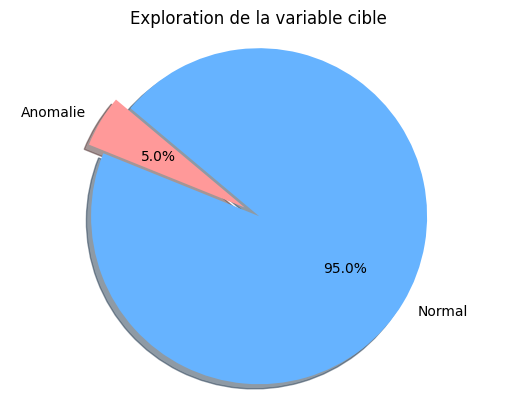

In [27]:
# Compter les occurrences de chaque catégorie
counts = df['Label'].value_counts()

# Préparer les données pour le diagramme circulaire
labels = ['Anomalie', 'Normal']
sizes = [counts[1], counts[0]]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)

# Créer le diagramme circulaire
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.axis('equal')  # Assure que le diagramme est dessiné en cercle.
plt.title('Exploration de la variable cible')

## Preprocessing 

In [ ]:
class DataPreprocessor:
    """
    Prétraitement des Données

    • Nettoyage : Imputer les valeurs manquantes.
    • Encodage des variables catégorielles : Appliquer l’encodage par variables factices (dummy variables)
      pour les données non numériques.
    • Standardisation : Standardiser les données numériques pour améliorer les performances des algorithmes.
    • Livrable : Code et documentation du pipeline de prétraitement des données.

    Attributes:
    -----------
    df : pd.DataFrame
        Le DataFrame contenant les données à traiter.
    target_column : str
        La colonne cible pour le modèle.
    exclude_columns : list
        Les colonnes à exclure du prétraitement (par défaut, aucune colonne n'est exclue).
    test_size : float
        La proportion de l'ensemble de test (par défaut, 0.2).
    random_state : int
        Graine aléatoire pour la reproductibilité du découpage en train/test (par défaut, 0).
    """
    
    def __init__(self, df, target_column, exclude_columns=None, test_size=0.2, random_state=0):
        
        self.df = df
        self.target_column = target_column
        self.exclude_columns = exclude_columns if exclude_columns is not None else []
        self.test_size = test_size
        self.random_state = random_state


    def impute_outliers(self, colname): 
        q1 = np.percentile(self.df[colname], 25)
        q3 = np.percentile(self.df[colname], 75) 

        lower_bound = q1 - 1.5*(q3 - q1)
        upper_bound = q3 + 1.5*(q3 - q1)

        self.df.loc[(self.df[colname] <= lower_bound), colname] = lower_bound
        self.df.loc[(self.df[colname] >= upper_bound), colname] = upper_bound

    def preprocess_data(self):
        """
        Impute les valeurs aberrantes pour toutes les colonnes numériques.
        """
        for colname in self.df.select_dtypes('number').columns:
            self.impute_outliers(colname)
        

    def split_data(self):
        """
        Divise les données en ensembles d'entraînement et de test.

        Returns:
        --------
        X_train, X_test, y_train, y_test : tuple
            Données divisées en ensembles d'entraînement et de test.
        """
        y = self.df[self.target_column]
        X = self.df.drop([self.target_column] + self.exclude_columns, axis='columns')
        
        X_train, X_test, y_train, y_test = train_test_split(
                                 X, 
                                 y, 
                                 test_size=self.test_size, 
                                 random_state=self.random_state
                            )
        return X_train, X_test, y_train, y_test
    
    

    def create_pipeline(self, X_train):
        """
        Crée un pipeline de prétraitement pour les données.

        Étapes du pipeline :
        - Imputation des valeurs manquantes.
        - Standardisation des colonnes numériques.
        - Encodage des variables catégorielles avec des variables factices.

        Parameters:
        -----------
        X_train : pd.DataFrame
            Données d'entraînement pour déterminer les types de colonnes.

        Returns:
        --------
        full_pipeline : ColumnTransformer
            Pipeline de transformations pour le prétraitement complet des données.
        """
        num_cols = X_train.select_dtypes(include=['number']).columns
        cat_cols = X_train.select_dtypes(include='object').columns
        num_pipeline = make_pipeline(
                    SimpleImputer(strategy='median'),
                    StandardScaler(),
                )
        cat_pipeline = make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore', drop='first')
                )
        full_pipeline = ColumnTransformer([
                            ('num', num_pipeline, num_cols),
                            ('cat', cat_pipeline, cat_cols)
                        ])
        return full_pipeline

In [ ]:
preprocessing = DataPreprocessor(df, 'Label',['Flow ID','Src IP','Src Port'	,'Dst IP','Dst Port','Protocol','Timestamp'],random_state=10)
X_train, X_test, y_train, y_test = preprocessing.split_data()
pipeline = preprocessing.create_pipeline(X_train)

In [ ]:
X_train_transform = pipeline.fit_transform(X_train)
X_test_transform = pipeline.transform(X_test)

In [22]:
# Pipeline avec SMOTE et LightGBM
pipeline = ImbPipeline(steps=[
    ('equilibrage_classes', SMOTE(sampling_strategy='auto', random_state=42)),  # Gestion du déséquilibre des classes
    ('modele', lgb.LGBMClassifier())  # Modèle LightGBM
])

In [21]:
# Optimisation des hyperparamètres avec GridSearchCV
grille_parametres = {
    'modele__num_leaves': [31, 50, 70],
    'modele__learning_rate': [0.01, 0.1, 0.2],
    'modele__n_estimators': [100, 200, 300]
}

recherche_grille = GridSearchCV(pipeline, grille_parametres, cv=5, scoring='f1', verbose=2, n_jobs=-1)
recherche_grille.fit(X_train_transform, y_train)

print("Meilleurs paramètres GridSearchCV :", recherche_grille.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:
# Optimisation des hyperparamètres avec Optuna
def fonction_objectif(essai):
    parametres = {
        'num_leaves': essai.suggest_int('num_leaves', 20, 100),
        'learning_rate': essai.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': essai.suggest_int('n_estimators', 50, 300)
    }
    modele_lightgbm = lgb.LGBMClassifier(**parametres)
    
    pipeline_optuna = ImbPipeline(steps=[
        ('equilibrage_classes', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE
        ('modele', modele_lightgbm)  # Modèle optimisé
    ])
    
    pipeline_optuna.fit(X_train_transform, y_train)
    return pipeline_optuna.score(X_test, y_test)

etude = optuna.create_study(direction='maximize')
etude.optimize(fonction_objectif, n_trials=20)

print("Meilleurs paramètres Optuna :", etude.best_params)

In [25]:
pipeline.fit(X_train_transform, y_train)

[LightGBM] [Info] Number of positive: 26806, number of negative: 26806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14704
[LightGBM] [Info] Number of data points in the train set: 53612, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('equilibrage_classes', SMOTE(random_state=42)),
                ('modele', LGBMClassifier())])

In [26]:
pipeline

Pipeline(steps=[('equilibrage_classes', SMOTE(random_state=42)),
                ('modele', LGBMClassifier())])